# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [10]:
X_treino = pd.read_csv('X_train.csv')
X_teste = pd.read_csv('X_test.csv')
y_treino = pd.read_csv('y_train.csv')
y_teste = pd.read_csv('y_test.csv')

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_treino, y_treino, test_size=0.25, random_state=5)

In [65]:
X_teste['Subject'] = 0  # Adiciona a coluna 'Subject' com todos os valores iguais a 0

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [66]:
# Substituir infinitos por NaN e verificar se ainda existem valores infinitos
X_treino.replace([np.inf, -np.inf], np.nan, inplace=True)
assert not np.isinf(X_treino.values).any(), "Ainda existem valores infinitos."

# Preencher NaNs com 0 (confirmar que todas as entradas são tratadas)
X_treino.fillna(0, inplace=True)
assert not X_treino.isna().any().any(), "Ainda existem valores NaN após preenchimento."

# Converter tipos, assegurando que todos são float32
X_treino = X_treino.astype('float32')
assert X_treino.dtypes.unique()[0] == np.float32, "Problemas na conversão para float32."

# Verificar explicitamente se há valores ausentes ou infinitos após todas as conversões
assert not np.isnan(X_treino.values).any(), "Existem NaNs nos dados."
assert not np.isinf(X_treino.values).any(), "Existem infinitos nos dados."

In [67]:
arvore = DecisionTreeClassifier(max_depth=4, random_state=5)
arvore.fit(X_train, y_train)
importances = arvore.feature_importances_

# Obtendo os índices das três variáveis mais importantes
indices = np.argsort(importances)[::-1][:3]

# Printar as três variáveis mais importantes
for i in indices:
    print(f"Variável {X_treino.columns[i]}: Importância {importances[i]:.4f}")

Variável Unnamed: 28: Importância 0.2500
Variável tBodyAcc-mean()-Z: Importância 0.2500
Variável Unnamed: 5: Importância 0.2500


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [68]:
important_columns = ['Unnamed: 52', 'Unnamed: 381', 'Unnamed: 41']

In [69]:
# Filtrando o conjunto de treino e validação para usar apenas as variáveis importantes
X_train_filtered = X_train[important_columns]
X_val_filtered = X_valid[important_columns]

In [70]:
# X_train_important deve conter apenas as três variáveis mais importantes
X_train_important = X_train[important_columns]

# Configurar o modelo inicial de Árvore de Decisão
arvore = DecisionTreeClassifier(max_depth=4, random_state=5)
arvore.fit(X_train_important, y_train)

# Utilizar cost_complexity_pruning_path para encontrar os possíveis valores de ccp_alpha
path = arvore.cost_complexity_pruning_path(X_train_important, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [71]:
ccp_alphas

array([0.        , 0.00018136, 0.00018136])

In [72]:
# Treinar um classificador para cada valor de ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=4, random_state=5, ccp_alpha=ccp_alpha)
    clf.fit(X_train_filtered, y_train)
    clfs.append(clf)

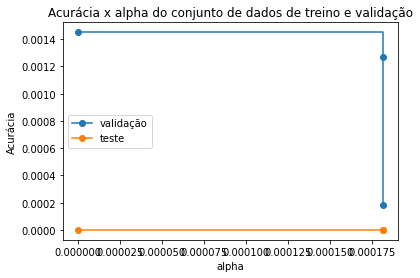

In [87]:
train_scores = [clf.score(X_train_filtered, y_train) for clf in clfs]
valid_scores = [clf.score(X_val_filtered, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

In [84]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 0.00


DecisionTreeClassifier(ccp_alpha=0.0001813565469713415, max_depth=4,
                       random_state=5)

In [85]:
X_teste_important = X_teste[important_columns]

Acurácia: 14.25


c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


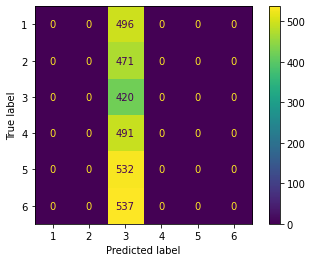

In [95]:
acuracia_teste = melhor_arvore.score(X_teste_important, y_teste)

print(f'Acurácia: {acuracia_teste*100:.2f}')
plot_confusion_matrix(melhor_arvore, X_teste_important, y_teste);

In [92]:
y_teste = y_teste.drop(columns=['Index'])

In [93]:
# Converter o DataFrame restante para uma Series
y_teste = y_teste.squeeze()

# Verificar os novos tipos de dados e forma
print(y_teste.dtypes)
print(y_teste.shape)

int64
(2947,)
